In [181]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import datetime
import scipy
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
#from keras.utils.vis_utils import plot_model
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error

In [191]:
# 1. Load Raw Data
csv_raw = pd.read_csv("./data/data_2024.csv", skiprows=1, parse_dates=['datetime'], dayfirst=False)

# 2. extract usable raw component(columns) ordered by datatime
raw_data = csv_raw[['datetime', 'warmup', 'off', 
                   'add_amount_brightener', 'add_amount_carrier', 
                   'velocity','tension','v','a','temperature',
                   'copper_sulfate_content', 'sulfuric_acid_content', 'chloride_content']].sort_values("datetime")

# 3. extracted column data
raw_warmup = raw_data[~raw_data["warmup"].isna()][["datetime", "warmup"]]
raw_off = raw_data[~raw_data["off"].isna()][["datetime", "off"]]
raw_brightener = (raw_data[~raw_data["add_amount_brightener"].isna()])[["datetime", "add_amount_brightener"]]
raw_carrier = (raw_data[~raw_data["add_amount_carrier"].isna()])[["datetime", "add_amount_carrier"]]
raw_velocity = (raw_data[~raw_data["velocity"].isna()])[["datetime", "velocity"]]
raw_tension = (raw_data[~raw_data["tension"].isna()])[["datetime", "tension"]]
raw_voltage = (raw_data[~raw_data["v"].isna()])[["datetime", "v"]]
raw_ampere = (raw_data[~raw_data["a"].isna()])[["datetime", "a"]]
raw_temperature = (raw_data[~raw_data["temperature"].isna()])[["datetime", "temperature"]]
raw_cs = (raw_data[~raw_data["copper_sulfate_content"].isna()])[["datetime", "copper_sulfate_content"]]
raw_sa = (raw_data[~raw_data["sulfuric_acid_content"].isna()])[["datetime", "sulfuric_acid_content"]]
raw_c = (raw_data[~raw_data["chloride_content"].isna()])[["datetime", "chloride_content"]]

print(raw_brightener)


                     datetime  add_amount_brightener
48  2023-07-18 08:35:00+00:00                  320.0
63  2023-07-19 08:45:00+00:00                  450.0
77  2023-07-20 08:35:00+00:00                  230.0
92  2023-07-24 12:35:00+00:00                  300.0
100 2023-07-25 08:35:00+00:00                  380.0
116 2023-07-26 08:35:00+00:00                  230.0
131 2023-07-27 08:35:00+00:00                  400.0
132 2023-08-22 08:45:00+00:00                  150.0
145 2023-08-24 08:35:00+00:00                  220.0
151 2023-08-31 08:45:00+00:00                    0.0
152 2023-09-06 08:50:00+00:00                  306.0
163 2023-09-07 08:35:00+00:00                  376.0
176 2023-09-08 08:35:00+00:00                  200.0
187 2023-09-11 12:40:00+00:00                  180.0
195 2023-09-12 08:35:00+00:00                  180.0
208 2023-09-13 08:45:00+00:00                  150.0
221 2023-09-14 08:35:00+00:00                  180.0
233 2023-09-15 08:40:00+00:00                 

In [206]:

pd.set_option('display.max_rows', None)  # 모든 행을 출력
pd.set_option('display.max_columns', None) # 모든 열을 출력
pd.set_option('display.width', 200)

#4. Create new data frame (for every single day operation)
raw_ext = pd.DataFrame(dtype=float, columns=['datetime', 'optime', 'optime_min', 'add_amount_brightener', 'add_amount_carrier', 
                                             'velocity', 'velocity_var', 'velocity_std',
                                             'tension','tension_var', 'tension_std',
                                             'voltage','voltage_var', 'voltage_std',
                                             'ampere','ampere_var', 'ampere_std',
                                             'temperature','temperature_var', 'temperature_std',
                                             'cs','cs_var', 'cs_std',
                                             'sa','sa_var', 'sa_std',
                                             'ch','c_var', 'c_std'])
# print(raw_ext.shape) # 0,29

#5. Calculate operation time (every single day)
for warmup, off in zip(raw_warmup.iterrows(), raw_off.iterrows()):
    value = [off[1]["datetime"], off[1]["datetime"]-warmup[1]["datetime"]] # 단위작업 시간을 기준으로 시간을 쪼개서 구분
    value.extend([np.nan for i in range(0, raw_ext.shape[1]-len(value))]) # 사전에 설정한 컬럼에 row를 모두 nan으로 채움
    raw_ext.loc[len(raw_ext.index)] = value # raw_ext에 하나씩 쌓음 (총 115번 작업)
    

raw_ext = raw_ext.groupby(pd.Grouper(key='datetime', freq='D', sort=True, )).sum() #같은 날짜에 두번작업하는 경우가 많아, 같은 날짜는 sum (key로 지정되었던 datetime은 컬럼에서 사라지고 index로 지정됨, 해제하려면 reset_index() 추가)
raw_ext = raw_ext[raw_ext["optime"]>datetime.timedelta(seconds=0)] # drop no timedelta, 작업시간이 0초보다 큰 경우에만 남겨둠. (115개 작업이 68개로 줄어듬. 총 68일에 해당하는 데이터)
raw_ext["optime_min"] = [i.total_seconds()/60 for i in raw_ext.loc[:,"optime"]] # add time min # 작업시간을 분으로 재표현
raw_ext = raw_ext.drop(columns="optime") # optime 컬럼 제거

print(raw_ext)


                           optime_min  add_amount_brightener  add_amount_carrier  velocity  velocity_var  velocity_std  tension  tension_var  tension_std  voltage  voltage_var  voltage_std  ampere  \
datetime                                                                                                                                                                                               
2023-07-11 00:00:00+00:00       330.0                    0.0                 0.0       0.0           0.0           0.0      0.0          0.0          0.0      0.0          0.0          0.0     0.0   
2023-07-12 00:00:00+00:00       295.0                    0.0                 0.0       0.0           0.0           0.0      0.0          0.0          0.0      0.0          0.0          0.0     0.0   
2023-07-13 00:00:00+00:00       280.0                    0.0                 0.0       0.0           0.0           0.0      0.0          0.0          0.0      0.0          0.0          0.0     0.0   


In [221]:

for t_idx in raw_ext.index: # 중복없는 datetime index를 기준으로 해당 날짜에 대한 데이터 추출
    
    mask_brightener = list((raw_brightener["datetime"]>t_idx) & (raw_brightener["datetime"]<=t_idx+datetime.timedelta(hours=24)))

    print("---")
    print(raw_brightener["datetime"])
    print("start : ", t_idx)
    print("end : ",t_idx+datetime.timedelta(hours=24))
    print("---")
    
    mask_carrier = list((raw_carrier["datetime"]>t_idx) & (raw_carrier["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_voltage = list((raw_voltage["datetime"]>t_idx) & (raw_voltage["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_ampere = list((raw_ampere["datetime"]>t_idx) & (raw_ampere["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_temperature = list((raw_temperature["datetime"]>t_idx) & (raw_temperature["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_tension = list((raw_tension["datetime"]>t_idx) & (raw_tension["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_velocity = list((raw_velocity["datetime"]>t_idx) & (raw_velocity["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_cs = list((raw_cs["datetime"]>t_idx) & (raw_cs["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_sa = list((raw_sa["datetime"]>t_idx) & (raw_sa["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_c = list((raw_c["datetime"]>t_idx) & (raw_c["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    
    
    print(raw_ext.loc[:, "add_amount_brightener"])
    print(mask_brightener)
    
    
    if any(mask_brightener):
        raw_ext.loc[t_idx, "add_amount_brightener"] = raw_brightener.loc[mask_brightener, "add_amount_brightener"].values[0]
    if any(mask_carrier):
        raw_ext.loc[t_idx, "add_amount_carrier"] = raw_carrier.loc[mask_carrier, "add_amount_carrier"].values[0]
    if any(mask_voltage):
        raw_ext.loc[t_idx, "voltage"] = raw_voltage.loc[mask_voltage, "v"].values.mean()
        raw_ext.loc[t_idx, "voltage_var"] = raw_voltage.loc[mask_voltage, "v"].values.var()
        raw_ext.loc[t_idx, "voltage_std"] = raw_voltage.loc[mask_voltage, "v"].values.std()
    if any(mask_ampere):
        raw_ext.loc[t_idx, "ampere"] = raw_ampere.loc[mask_voltage, "a"].values.mean()
        raw_ext.loc[t_idx, "ampere_var"] = raw_ampere.loc[mask_voltage, "a"].values.var()
        raw_ext.loc[t_idx, "ampere_std"] = raw_ampere.loc[mask_voltage, "a"].values.std()
    if any(mask_temperature):
        #print(raw_temperature.loc[mask_temperature, "temperature"].values)
        raw_ext.loc[t_idx, "temperature"] = raw_temperature.loc[mask_temperature, "temperature"].values.mean()
        raw_ext.loc[t_idx, "temperature_var"] = raw_temperature.loc[mask_temperature, "temperature"].values.var()
        raw_ext.loc[t_idx, "temperature_std"] = raw_temperature.loc[mask_temperature, "temperature"].values.std()
    if any(mask_cs):
        raw_ext.loc[t_idx, "cs"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].values.mean()
        raw_ext.loc[t_idx, "cs_var"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].values.var()
        raw_ext.loc[t_idx, "cs_std"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].values.std()
    if any(mask_sa):
        raw_ext.loc[t_idx, "sa"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].values.mean()
        raw_ext.loc[t_idx, "sa_var"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].values.var()
        raw_ext.loc[t_idx, "sa_std"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].values.std()
    if any(mask_c):
        raw_ext.loc[t_idx, "ch"] = raw_c.loc[mask_cs, "chloride_content"].values.mean()
        raw_ext.loc[t_idx, "ch_var"] = raw_c.loc[mask_cs, "chloride_content"].values.var()
        raw_ext.loc[t_idx, "ch_std"] = raw_c.loc[mask_cs, "chloride_content"].values.std()
    if any(mask_velocity):
        raw_ext.loc[t_idx, "velocity"] = raw_velocity.loc[mask_velocity, "velocity"].values.mean()
        raw_ext.loc[t_idx, "velocity_var"] = raw_velocity.loc[mask_velocity, "velocity"].values.var()
        raw_ext.loc[t_idx, "velocity_std"] = raw_velocity.loc[mask_velocity, "velocity"].values.std()
    if any(mask_tension):
        raw_ext.loc[t_idx, "tension"] = raw_tension.loc[mask_tension, "tension"].values.mean()
        raw_ext.loc[t_idx, "tension_var"] = raw_tension.loc[mask_tension, "tension"].values.var()
        raw_ext.loc[t_idx, "tension_std"] = raw_tension.loc[mask_tension, "tension"].values.std()

---
48    2023-07-18 08:35:00+00:00
63    2023-07-19 08:45:00+00:00
77    2023-07-20 08:35:00+00:00
92    2023-07-24 12:35:00+00:00
100   2023-07-25 08:35:00+00:00
116   2023-07-26 08:35:00+00:00
131   2023-07-27 08:35:00+00:00
132   2023-08-22 08:45:00+00:00
145   2023-08-24 08:35:00+00:00
151   2023-08-31 08:45:00+00:00
152   2023-09-06 08:50:00+00:00
163   2023-09-07 08:35:00+00:00
176   2023-09-08 08:35:00+00:00
187   2023-09-11 12:40:00+00:00
195   2023-09-12 08:35:00+00:00
208   2023-09-13 08:45:00+00:00
221   2023-09-14 08:35:00+00:00
233   2023-09-15 08:40:00+00:00
239   2023-09-18 08:55:00+00:00
252   2023-09-19 08:48:00+00:00
265   2024-01-29 08:50:00+00:00
274   2024-01-30 08:50:00+00:00
286   2024-01-31 08:50:00+00:00
299   2024-02-13 08:50:00+00:00
314   2024-02-19 08:50:00+00:00
328   2024-02-20 08:50:00+00:00
340   2024-02-29 08:40:00+00:00
352   2024-03-04 08:50:00+00:00
381   2024-03-07 08:50:00+00:00
396   2024-03-11 08:50:00+00:00
410   2024-03-12 08:50:00+00:00
423 

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [114]:

        
# 7. drop the row with nan value of add_amount_brightener
raw_prepared = raw_ext.loc[raw_ext["add_amount_brightener"]!=0.0]

# 7.1 save to csv file
raw_prepared.to_csv('./aggregate_2024.csv', sep=',')


# 8. stand scaler
optime_scaler = StandardScaler()
brightener_scaler = StandardScaler()
carrier_scaler = StandardScaler()
voltage_scaler = StandardScaler()
ampere_scaler = StandardScaler()
temperaature_scaler = StandardScaler()
cs_scaler = StandardScaler()
sa_scaler = StandardScaler()
ch_scaler = StandardScaler()
velocity_scaler = StandardScaler()
tension_scaler = StandardScaler()

optime_mean_normalized = optime_scaler.fit_transform(raw_prepared.loc[:,"optime_min"].ravel().reshape(-1, 1)).flatten()
add_amount_brightener_normalized = brightener_scaler.fit_transform(raw_prepared.loc[:,"add_amount_brightener"].ravel().reshape(-1, 1)).flatten()
add_amount_carrier_normalized = carrier_scaler.fit_transform(raw_prepared.loc[:,"add_amount_carrier"].ravel().reshape(-1, 1)).flatten()
voltage_normalized = voltage_scaler.fit_transform(raw_prepared.loc[:,"voltage"].ravel().reshape(-1, 1)).flatten()
ampere_normalized = ampere_scaler.fit_transform(raw_prepared.loc[:,"ampere"].ravel().reshape(-1, 1)).flatten()
temperature_normalized = temperaature_scaler.fit_transform(raw_prepared.loc[:,"temperature"].ravel().reshape(-1, 1)).flatten()
cs_normalized = cs_scaler.fit_transform(raw_prepared.loc[:,"cs"].ravel().reshape(-1, 1)).flatten()
sa_normalized = sa_scaler.fit_transform(raw_prepared.loc[:,"sa"].ravel().reshape(-1, 1)).flatten()
velocity_normalized = velocity_scaler.fit_transform(raw_prepared.loc[:,"velocity"].ravel().reshape(-1, 1)).flatten()
tension_normalized = tension_scaler.fit_transform(raw_prepared.loc[:,"tension"].ravel().reshape(-1, 1)).flatten()

# 9. correlation analysis
X = raw_prepared.loc[:,["optime_min", "add_amount_brightener", "add_amount_carrier", "velocity", "voltage", "ampere", "cs", "sa", "tension", "temperature"]]
corr = X.corr()
sns.heatmap(corr, cmap='viridis')
plt.show()

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

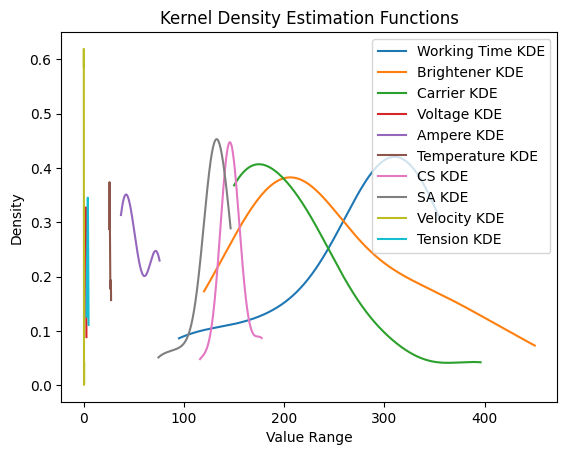

In [53]:
# kernel density estimation to resample more data
bw = 'scott'
optime_kde = gaussian_kde(optime_mean_normalized, bw_method=bw)
brightener_kde = gaussian_kde(add_amount_brightener_normalized, bw_method=bw)
carrier_kde = gaussian_kde(add_amount_carrier_normalized, bw_method=bw)
voltage_kde = gaussian_kde(voltage_normalized, bw_method=bw)
ampere_kde = gaussian_kde(ampere_normalized, bw_method=bw)
temperature_kde = gaussian_kde(temperature_normalized, bw_method=bw)
cs_kde = gaussian_kde(cs_normalized, bw_method=bw)
sa_kde = gaussian_kde(sa_normalized, bw_method=bw)
velocity_kde = gaussian_kde(velocity_normalized, bw_method=bw)
tension_kde = gaussian_kde(tension_normalized, bw_method=bw)

# resample from kde
n_sample = 1000

x_optime = np.linspace(min(optime_mean_normalized), max(optime_mean_normalized), n_sample)
x_brightener = np.linspace(min(add_amount_brightener_normalized), max(add_amount_brightener_normalized), n_sample)
x_carrier = np.linspace(min(add_amount_carrier_normalized), max(add_amount_carrier_normalized), n_sample)
x_voltage = np.linspace(min(voltage_normalized), max(voltage_normalized), n_sample)
x_ampere = np.linspace(min(ampere_normalized), max(ampere_normalized), n_sample)
x_temperature = np.linspace(min(temperature_normalized), max(temperature_normalized), n_sample)
x_cs = np.linspace(min(cs_normalized), max(cs_normalized), n_sample)
x_sa = np.linspace(min(sa_normalized), max(sa_normalized), n_sample)
x_velocity = np.linspace(min(velocity_normalized), max(velocity_normalized), n_sample)
x_tension = np.linspace(min(tension_normalized), max(tension_normalized), n_sample)

optime_df = optime_kde(x_optime)
brightener_df = brightener_kde(x_brightener)
carrier_df = carrier_kde(x_carrier)
voltage_df = voltage_kde(x_voltage)
ampere_df = ampere_kde(x_ampere)
temperature_df = temperature_kde(x_temperature)
cs_df = cs_kde(x_cs)
sa_df = sa_kde(x_sa)
velocity_df = velocity_kde(x_velocity)
tension_df = tension_kde(x_tension)


rx_optime = optime_scaler.inverse_transform(x_optime.reshape(1, -1)).flatten()
rx_brightener = brightener_scaler.inverse_transform(x_brightener.reshape(1, -1)).flatten()
rx_carrier = carrier_scaler.inverse_transform(x_carrier.reshape(1, -1)).flatten()
rx_voltage = voltage_scaler.inverse_transform(x_voltage.reshape(1, -1)).flatten()
rx_ampere = ampere_scaler.inverse_transform(x_ampere.reshape(1, -1)).flatten()
rx_temperature = temperaature_scaler.inverse_transform(x_temperature.reshape(1, -1)).flatten()
rx_cs = cs_scaler.inverse_transform(x_cs.reshape(1, -1)).flatten()
rx_sa = sa_scaler.inverse_transform(x_sa.reshape(1, -1)).flatten()
rx_velocity = velocity_scaler.inverse_transform(x_velocity.reshape(1, -1)).flatten()
rx_tension = tension_scaler.inverse_transform(x_tension.reshape(1, -1)).flatten()


plt.plot(rx_optime, optime_df, label='Working Time KDE')
plt.plot(rx_brightener, brightener_df, label='Brightener KDE')
plt.plot(rx_carrier, carrier_df, label='Carrier KDE')
plt.plot(rx_voltage, voltage_df, label='Voltage KDE')
plt.plot(rx_ampere, ampere_df, label='Ampere KDE')
plt.plot(rx_temperature, temperature_df, label='Temperature KDE')
plt.plot(rx_cs, cs_df, label='CS KDE')
plt.plot(rx_sa, sa_df, label='SA KDE')
plt.plot(rx_velocity, velocity_df, label='Velocity KDE')
plt.plot(rx_tension, tension_df, label='Tension KDE')
plt.xlabel('Value Range')
plt.ylabel('Density')
plt.title('Kernel Density Estimation Functions')
plt.legend()
plt.show()

In [78]:
# Modeling
from tensorflow.keras import layers, models

# correlation
X = pd.DataFrame([x_optime.T, x_voltage.T, x_ampere.T, x_temperature.T, x_cs.T, x_sa.T, x_tension.T, x_velocity.T]).T
y = pd.DataFrame([x_brightener.T, x_carrier.T]).T
X.columns = ['optime', 'voltage', 'Ampere', "Temperature", "copper_sulfate", "sulfuric_acid", "Tension", "Velocity"]
y.columns = ['brightener', 'carrier']
# corr = X.corr()
# sns.heatmap(corr, cmap='viridis')
# plt.show()


# model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
model = models.Sequential()
model.add(layers.Input(shape=(X.shape[1],))) # input layer
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(y.shape[1], activation='linear'))


#plot_model(model, to_file="./model.png", show_shapes=True, show_layer_names=True)
model.compile(loss='mean_squared_error', optimizer='sgd')
print(f"X_train:{X_train.shape}, y_train:{y_train.shape}, X_test:{X_test.shape}, y_test:{y_test.shape}")
history = model.fit(X_train, y_train, epochs=20, batch_size=5, verbose=1)
y_pred = model.predict(X_test)

# output inverse transform
brightener_pred_output = brightener_scaler.inverse_transform(y_pred[:,0].reshape(1, -1)).flatten()
brightener_test_output = brightener_scaler.inverse_transform(y_test["brightener"].values.reshape(1, -1)).flatten()
carrier_pred_output = carrier_scaler.inverse_transform(y_pred[:,1].reshape(1, -1)).flatten()
carrier_test_output = carrier_scaler.inverse_transform(y_test["carrier"].values.reshape(1, -1)).flatten()

plt.scatter(brightener_test_output, brightener_pred_output, color='b', label='Brightener')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Multivariate Neural Network Prediction Results of Brighener')
plt.legend()
plt.show()

plt.scatter(carrier_test_output, carrier_pred_output, color='r', label='Carrier')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Multivariate Neural Network Prediction Results of Carrier')
plt.legend()
plt.show()

# learning curve
print(history.history.keys())
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae = mean_absolute_error(carrier_test_output, carrier_pred_output)
print(f"Mean Absolute Error : {mae}")

mse = mean_squared_error(carrier_test_output, carrier_pred_output)
print(f"Mean Squared Error : {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared Result : {r2}")

vs = explained_variance_score(carrier_test_output, carrier_pred_output)
print(f"Explained Variance Score : {vs}")

X_train:(700, 8), y_train:(700, 2), X_test:(300, 8), y_test:(300, 2)


ValueError: object __array__ method not producing an array